### Installing dependencies for preprocessing of images

In [1]:
!pip install imutils

  Created wheel for imutils: filename=imutils-0.5.3-py3-none-any.whl size=25850 sha256=163904b9c04651341eb9510f445ad6dbe244f8ddd0ea51be19708c72da70b2f7
  Stored in directory: /root/.cache/pip/wheels/fc/9c/6d/1826267c72afa51b564c9c6e0f66abc806879338bc593a2270
Successfully built imutils
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


**### Helper Functions

In [2]:
import numpy as np 
import pandas as pd 
import os
from os import listdir
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import imutils    

from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D, Dropout
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle #shuffling the data improves the model


### Loading Images

In [3]:
image_dir="../input/brain-mri-images-for-brain-tumor-detection/"

### Making directory for augmented images

**A directory is formed using os.makedirs() function for augmented images(yes/ no). Note- custom directory is obtained in outputs folder.**

In [4]:
os.makedirs('../output/kaggle/working/augmented-images')
os.makedirs('../output/kaggle/working/augmented-images/yes')
os.makedirs('../output/kaggle/working/augmented-images/no')

## Augmentation of images 
**About the data:
The dataset contains 2 folders: yes and no which contains 253 Brain MRI Images. The folder yes contains 155 Brain MRI Images that are tumorous andno contains 98 Brain MRI Images that are non-tumorous.**

In [5]:


def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.1, 
                                  shear_range=0.1, 
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True, 
                                  vertical_flip=True, 
                                  fill_mode='nearest'
                                 )

    for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        # reshape the image
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break

In [6]:
augmented_data_path ='../output/kaggle/working/augmented-images/'
# augment data for the examples with label equal to 'yes' representing tumurous examples
augment_data(file_dir=image_dir+'yes',n_generated_samples=6, save_to_dir=augmented_data_path+'yes')
# augment data for the examples with label equal to 'no' representing non-tumurous examples
augment_data(file_dir=image_dir+'no', n_generated_samples=9, save_to_dir=augmented_data_path+'no')

## Preprocessing the data

In order to crop the specific part of the image containing tumour,cropping technique via OpenCv is used, the details can be found here.[How to find extreme points in OpenCv?](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/)

In [7]:
def crop_brain_contour(image, plot=False):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

## After applying the cropping function

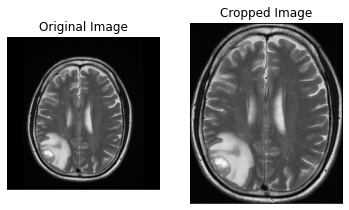

In [8]:
ex_img = cv2.imread(image_dir+'yes/Y107.jpg')
ex_crop_img = crop_brain_contour(ex_img, True)

In [9]:
def load_data(dir_list, image_size):

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            image = crop_brain_contour(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [10]:
augmented_yes =augmented_data_path+'yes'
augmented_no = augmented_data_path+'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)


## Visualization of data

In [11]:
def plot_sample_images(X, y, n=40):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 8))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

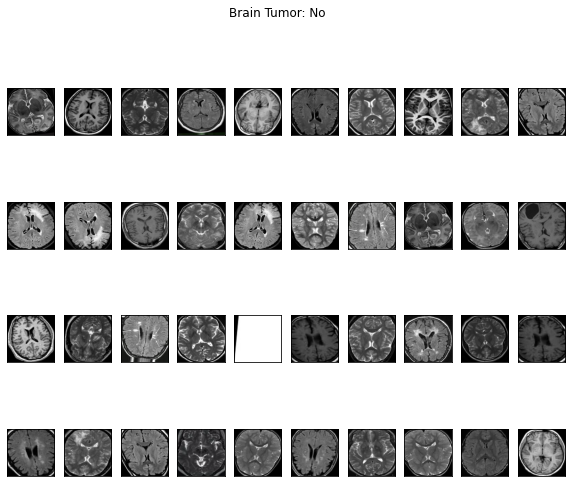

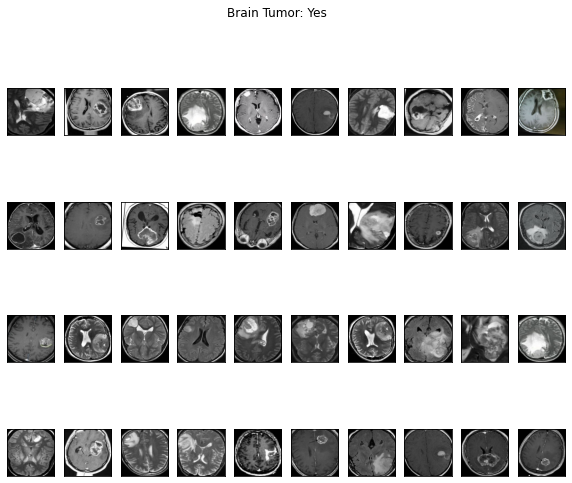

In [12]:
plot_sample_images(X, y)

In [13]:
def split_data(X, y, test_size=0.2):
       
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [14]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [15]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

number of training examples = 1445
number of validation examples = 310
number of test examples = 310


In [23]:
def build_model(input_shape):
    X_input = Input(input_shape) 
    X = ZeroPadding2D((2, 2))(X_input) 
    
    X = Conv2D(32, (7, 7), strides = (1, 1))(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)
    X = Dropout(0.2)(X)
    
    
#     X = MaxPooling2D((4, 4))(X) 
    X = MaxPooling2D((4, 4))(X) 
    X = Flatten()(X) 
    X = Dense(1, activation='sigmoid')(X) 
    model = Model(inputs = X_input, outputs = X)
    
    return model

In [24]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model=build_model(IMG_SHAPE)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 244, 244, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 238, 238, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 238, 238, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 238, 238, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 238, 238, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 59, 59, 32)       

In [25]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x=X_train, y=y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val))

Epoch 1/50
46/46 [==============================] - 2s 49ms/step - loss: 4.1378 - accuracy: 0.6208 - val_loss: 0.9275 - val_accuracy: 0.5806
Epoch 2/50
46/46 [==============================] - 2s 41ms/step - loss: 1.2500 - accuracy: 0.7599 - val_loss: 1.1474 - val_accuracy: 0.5806
Epoch 3/50
46/46 [==============================] - 2s 43ms/step - loss: 0.6817 - accuracy: 0.8464 - val_loss: 1.0578 - val_accuracy: 0.5968
Epoch 4/50
46/46 [==============================] - 2s 43ms/step - loss: 0.5878 - accuracy: 0.8644 - val_loss: 0.5017 - val_accuracy: 0.7871
Epoch 5/50
46/46 [==============================] - 2s 42ms/step - loss: 0.1896 - accuracy: 0.9405 - val_loss: 0.5112 - val_accuracy: 0.7710
Epoch 6/50
46/46 [==============================] - 2s 42ms/step - loss: 0.3102 - accuracy: 0.9183 - val_loss: 0.5742 - val_accuracy: 0.7516
Epoch 7/50
46/46 [==============================] - 2s 42ms/step - loss: 0.1440 - accuracy: 0.9509 - val_loss: 1.6497 - val_accuracy: 0.6129
Epoch 8/50
46

In [19]:
history = model.history.history

In [20]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

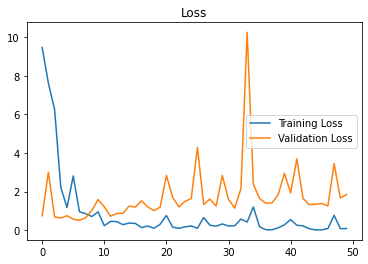

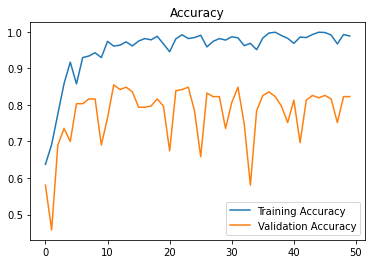

In [22]:
plot_metrics(history)

In [ ]:
def build_model(input_shape):
    X_input = Input(input_shape) 
    X = ZeroPadding2D((2, 2))(X_input) 
    
    X = Conv2D(32, (7, 7), strides = (1, 1))(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) 
    
    X = MaxPooling2D((4, 4))(X) 
    X = MaxPooling2D((4, 4))(X) 
    X = Flatten()(X) 
    X = Dense(1, activation='sigmoid')(X) 
    model = Model(inputs = X_input, outputs = X)
    
    return model

In [ ]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model=build_model(IMG_SHAPE)
model.summary()

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x=X_train, y=y_train, batch_size=32, epochs=22, validation_data=(X_val, y_val))

In [ ]:
history = model.history.history

In [ ]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

### Plotting of accuracy

In [ ]:
plot_metrics(history)

#### Adding a drop out layer of 0.5 

In [ ]:
from tensorflow.keras.layers import Dropout

In [ ]:
def build_model_1(input_shape):
    X_input = Input(input_shape) 
    X = ZeroPadding2D((2, 2))(X_input) 
    
    X = Conv2D(32, (7, 7), strides = (1, 1))(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) 
    X = Dropout(0.5)(X)
    
    X = MaxPooling2D((4, 4))(X) 
    X = MaxPooling2D((4, 4))(X) 
    X = Flatten()(X) 
    X = Dense(1, activation='sigmoid')(X) 
    model_1 = Model(inputs = X_input, outputs = X)
    
    return model_1

In [ ]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model_1=build_model(IMG_SHAPE)
model_1.summary()

In [ ]:
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_1.fit(x=X_train, y=y_train, batch_size=32, epochs=22, validation_data=(X_val, y_val))

In [ ]:
history_1 = model_1.history.history

In [ ]:
### Plotting of accuracy

In [ ]:
plot_metrics(history_1)

## Building model with following changes
    adding a dense layer relu of value to 64
    Made the drop-out layer to 0.3
    Epochs to 50

In [ ]:
# added a dense layer relu of value to 64
# changed the drop-out layer to 0.3

In [ ]:
def build_model_2(input_shape):
    X_input = Input(input_shape) 
    X = ZeroPadding2D((2, 2))(X_input) 
    X = Conv2D(32, (7, 7), strides = (1, 1))(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) 
    X = Dropout(0.3)(X)
    X = MaxPooling2D((4, 4))(X) 
    X = Flatten()(X) 
    X = Dense(64, activation='relu')(X)
    X = Dense(1, activation='sigmoid')(X) 
    model_2 = Model(inputs = X_input, outputs = X)
    
    return model_2

In [ ]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model_2=build_model_2(IMG_SHAPE)
model_2.summary()

In [ ]:
# changes Epochs to 50
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_2.fit(x=X_train, y=y_train, batch_size=32, epochs=50, validation_data=(X_val, y_val))

In [ ]:
history_2 = model_1.history.history

In [ ]:
plot_metrics(history_2)

In [ ]:
## conv (3,3)
# Changed the epochs to 30
# dense layer to 59
# Maxpooling to 2,2
# drop out to 0.5

In [ ]:
def build_model_3(input_shape):
    X_input = Input(input_shape) 
    X = ZeroPadding2D((2, 2))(X_input) 
    X = Conv2D(32, (3, 3), strides = (1, 1))(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) 
    X = Dropout(0.5)(X)
    X = MaxPooling2D((2, 2))(X)
    
    X = Flatten()(X) 
    X = Dense(59, activation='relu')(X)
    X = Dense(1, activation='sigmoid')(X) 
    model_3 = Model(inputs = X_input, outputs = X)
    
    return model_3

In [ ]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model_3=build_model_1(IMG_SHAPE)
model_3.summary()

In [ ]:
model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_3.fit(x=X_train, y=y_train, batch_size=32, epochs=30, validation_data=(X_val, y_val))

In [ ]:
history_3 = model_3.history.history

In [ ]:
plot_metrics(history_3)

## conv (3,3)
## Changed the epochs to 30
## dense layer to 59
## Maxpooling to 2,2
## drop out to 0.5

## adding one more convolution of same layers

In [ ]:
def build_model_4(input_shape):
    X_input = Input(input_shape) 
    X = ZeroPadding2D((2, 2))(X_input) 
    X = Conv2D(32, (3, 3), strides = (1, 1))(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) 
    X = Dropout(0.5)(X)
    X = MaxPooling2D((2, 2))(X)
    
    X = ZeroPadding2D((2, 2))(X)
    X = Conv2D(32, (3, 3), strides = (1, 1))(X)
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = Activation('relu')(X)
    X = Dropout(0.5)(X)
    X = MaxPooling2D((2, 2))(X)
    
    X = Flatten()(X) 
    X = Dense(59, activation='relu')(X)
    X = Dense(1, activation='sigmoid')(X) 
    model_4 = Model(inputs = X_input, outputs = X)
    
    return model_4

In [ ]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model_4=build_model_4(IMG_SHAPE)
model_4.summary()

In [ ]:
model_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_4.fit(x=X_train, y=y_train, batch_size=32, epochs=30, validation_data=(X_val, y_val))

In [ ]:
history_4 = model_4.history.history

In [ ]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
plot_metrics(history_4)

In [ ]:
def build_model_5(input_shape):
    X_input = Input(input_shape) 
    X = ZeroPadding2D((2, 2))(X_input) 
    X = Conv2D(32, (3, 3), strides = (1, 1))(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) 
    X = Dropout(0.2)(X)
    X = MaxPooling2D((2, 2))(X)
    X = MaxPooling2D((2, 2))(X)
    
    X = Flatten()(X) 
    X = Dense(59, activation='relu')(X)
    X = Dense(1, activation='sigmoid')(X) 
    model_4 = Model(inputs = X_input, outputs = X)
    
    return model_4

In [ ]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model_5=build_model_5(IMG_SHAPE)
model_5.summary()

In [ ]:
model_5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_5.fit(x=X_train, y=y_train, batch_size=32, epochs=30, validation_data=(X_val, y_val))

In [ ]:
history_5 = model_5.history.history

In [ ]:
plot_metrics(history_5)